In [ ]:
## Hyperparameters are tuned in this notebook

In [1]:
import h5py
import warnings
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (8,6)
warnings.filterwarnings('ignore')

In [3]:
## Define data file paths
TRAIN_FILE_PATH = './datasets/train_catvnoncat.h5'
TEST_FILE_PATH = './datasets/test_catvnoncat.h5'

In [4]:
## Utlities
def load_dataset(train_file_path, test_file_path):
    
    train = h5py.File(train_file_path)
    test = h5py.File(test_file_path)
    
    labels = np.array(train['list_classes'].value, dtype = str)
    
    X_train = train['train_set_x'].value
    y_train = train['train_set_y'].value
    
    X_test = test['test_set_x'].value
    y_test = test['test_set_y'].value
    
    print(f"Train data shape : {X_train.shape}")
    print(f"Test data shape : {X_test.shape}")
    print(f"Number of classes : {labels}")
    return X_train, y_train, X_test, y_test, labels

In [5]:
X_train, y_train, X_test, y_test, labels = load_dataset(TRAIN_FILE_PATH, TEST_FILE_PATH)

Train data shape : (209, 64, 64, 3)
Test data shape : (50, 64, 64, 3)
Number of classes : ['non-cat' 'cat']



    Below image is : non-cat


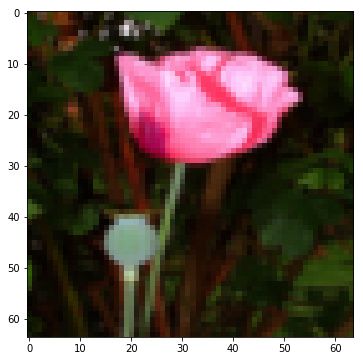

In [6]:
## Check the images and labels
index = 30
print(f"\n    Below image is : {labels[y_train[index]]}")
_ = plt.imshow(X_train[index,:,:,:],)

## Normalize Inputs

In [7]:
X_train = X_train/255.0
X_test = X_test/255.0

## Create Feature Vector

In [8]:
X_train = X_train.reshape([X_train.shape[0],-1])
y_train = y_train.reshape([y_train.shape[0],1])

X_test = X_test.reshape([X_test.shape[0],-1])
y_test = y_test.reshape([y_test.shape[0],1])

In [9]:
print(f"Train data shape : {X_train.shape}")
print(f"Test data shape : {X_test.shape}")

Train data shape : (209, 12288)
Test data shape : (50, 12288)


## Converting data to tensor

In [10]:
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

In [11]:
def accuracy(y_pred , y_true):
    y_true = y_true.flatten().numpy()
    y_pred = y_pred.flatten().numpy()
    
    accuarcy = np.round(np.mean(y_pred==y_true)* 100,2)
    return accuarcy

## Model Implementation

In [12]:
class SingleLayerLinearModel(nn.Module):
    
    def __init__(self, input_features):
        super(SingleLayerLinearModel,self).__init__()
        self.linear1 = nn.Linear(in_features=input_features, out_features = 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,X):
        z = self.linear1(X)
        a = self.sigmoid(z)
        return a
    
    def predict(self,X):
        a = self.forward(X)
        y_pred = a.flatten()>0.5 if 1 else 0
        return y_pred
    
    
class TwoLayerLinearModel(nn.Module):
    
    def __init__(self, input_features):
        super(TwoLayerLinearModel,self).__init__()
        self.linear1 = nn.Linear(in_features=input_features, out_features = 512)
        self.linear2 = nn.Linear(in_features=512, out_features = 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,X):
        a1 = self.relu(self.linear1(X))
        a2 = self.sigmoid(self.linear2(a1))
        return a2
    
    def predict(self,X):
        a = self.forward(X)
        y_pred = a.flatten()>0.5 if 1 else 0
        return y_pred

In [13]:
epochs = 2500
learning_rate = 1e-4

## Single layer

In [14]:
model = SingleLayerLinearModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn  = nn.BCEWithLogitsLoss(reduction='mean')

for epoch in range(epochs):
    
    ## model training
    model.train()
    
    ## Forward
    a = model.forward(X_train_tensor)
    
    ## calculate loss
    loss = loss_fn(a,y_train_tensor)
    
    # backward
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()

y_pred_train = model.predict(X_train_tensor)
print("Train accuracy : ",accuracy(y_pred_train,y_train_tensor))

y_pred_test = model.predict(X_test_tensor)
print("Test accuracy : ",accuracy(y_pred_test,y_test_tensor))

Train accuracy :  89.95
Test accuracy :  64.0


## Two Layer

In [15]:
model = TwoLayerLinearModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn  = nn.BCEWithLogitsLoss(reduction='mean')

for epoch in range(epochs):
    
    ## model training
    model.train()
    
    ## Forward
    a = model.forward(X_train_tensor)
    
    ## calculate loss
    loss = loss_fn(a,y_train_tensor)
    
    # backward
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()

y_pred_train = model.predict(X_train_tensor)
print("Train accuracy : ",accuracy(y_pred_train,y_train_tensor))

y_pred_test = model.predict(X_test_tensor)
print("Test accuracy : ",accuracy(y_pred_test,y_test_tensor))

Train accuracy :  90.91
Test accuracy :  60.0


## Another way to write model in Pytorch

In [16]:
from pytorch_lightning.callbacks.base import Callback
from pytorch_lightning import Trainer

In [17]:
# class PlotsCallback(Callback):
    
#     def __init__(self):
#         self.train_losses = []
#         self.test_losses = []
#         self.fig, self.axes = plt.subplots(1,1)
        
#     def on_epoch_end(self, train_loss, val_loss):
        
#         self.train_losses.append(train_loss)
#         self.test_losses.append(val_loss)
        
        
#         df = pd.concat([pd.DataFrame(self.train_losses), pd.DataFrame(self.test_losses)], axis=1)
#         df.columns =['train','val']
#         df.plot(ax = self.axes)
#         plt.show()
# #         self.axes.clear()

In [18]:
class LinearModel(nn.Module):
    
    def __init__(self, input_features):
        super(LinearModel,self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.linear1 = nn.Linear(in_features=input_features, out_features = 1024)
        self.linear2 = nn.Linear(in_features=1024, out_features = 512)
        self.linear3 = nn.Linear(in_features=512, out_features = 1)
        
    
    def forward(self,X):
        a1 = self.relu(self.linear1(X))
        a2 = self.relu(self.linear2(a1))
        a3 = self.sigmoid(self.linear3(a2))
        return a3

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, X,y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        input_dict = {"X": self.X[index],"y": self.y[index]}
        return input_dict
    
    def __len__(self):
        return len(self.X)

In [28]:
def accuracy(y_pred , y_true):
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    accuarcy = np.round(np.mean(y_pred==y_true)* 100,2)
    return accuarcy

def evaluate(dataloader):
    
    ## dont modify the model parametr
    model.eval()
    
    y_pred_list = []
    y_true_list = []
    
    for dataset in dataloader:
        X,y = dataset["X"], dataset["y"]
        y_logits = model.forward(X)
        y_logits = y_logits.flatten()
        y_pred = y_logits>=0.5 if 1.0 else 0.0
        
        y_pred_list += list(y_pred.numpy())
        y_true_list += list(y.flatten().numpy())
    
    
    return y_pred_list, y_true_list

def train(train_dataloader, test_dataloader, epochs):
     
    training_loss_list = []
    validation_loss_list = []
    
    loss_progress_bar = tqdm(range(epochs),leave = False,disable = False)
    
    for epoch in range(epochs):
        
        training_running_loss = 0
        validation_running_loss = 0
        
        ## Training
        model.train()
        
        progress_bar = tqdm(train_dataloader,
                            desc="Epoch :{:1d}".format(epoch),
                            leave = False,
                            disable = False
                           )
        
        for batch in progress_bar:
            X,y = batch["X"], batch["y"]
            
            y_logits = model.forward(X)
            
            loss = loss_fn(y_logits, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            ## gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
            ## optimizer
            optimizer.step()
            
            training_running_loss += loss.item()
            progress_bar.set_postfix({"Train Loss " : "{:.3f}".format(loss.item()/len(batch))})
        
        
        ## Validation
        model.eval()
        
        for dataset in test_dataloader:
            X,y = dataset["X"], dataset["y"]
            y_logits = model.forward(X)
            loss = loss_fn(y_logits, y)
            validation_running_loss += loss.item()
            
        training_running_loss /= len(train_dataloader)
        validation_running_loss /= len(test_dataloader)
        
        ## New tqdm
        loss_dict = {"Train Loss": training_running_loss, "Val loss": validation_running_loss}
        loss_progress_bar.set_postfix(loss_dict)
        loss_progress_bar.set_description("Loss after Epoch : {}".format(epoch))
        

        training_loss_list.append(training_running_loss)
        validation_loss_list.append(validation_running_loss)
    
    return (training_loss_list, validation_loss_list)

In [29]:
input_features = X_train.shape[1]
epochs = 20
learning_rate = 1e-4
batch_size = 16

In [30]:
train_dataset = CustomDataset(X_train_tensor,y_train_tensor)
test_dataset = CustomDataset(X_test_tensor,y_train_tensor)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, sampler= RandomSampler(train_dataset))
test_dataloader = DataLoader(test_dataset,batch_size=batch_size, sampler= SequentialSampler(test_dataset))

In [31]:
model = LinearModel(input_features)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn  = nn.BCEWithLogitsLoss(reduction='mean')

In [32]:
train_losses,test_losses  = train(train_dataloader, test_dataloader, epochs)

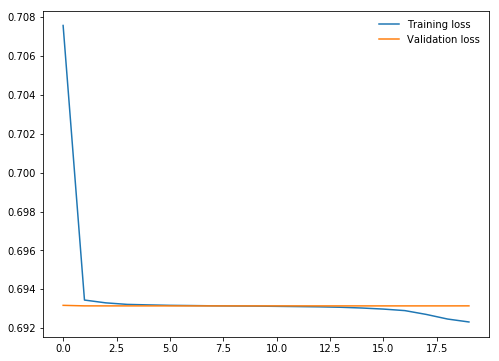

In [33]:
## Plot Training and Validation Loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [34]:
y_train_pred, y_train_true = evaluate(train_dataloader)
y_test_pred, y_test_true = evaluate(test_dataloader)

In [35]:
print("Train accuracy : ",accuracy(y_train_pred,y_train_true))
print("Test accuracy : ",accuracy(y_test_pred,y_test_true))

Train accuracy :  66.03
Test accuracy :  72.0
